## Examine clusters within the dataset as a whole





#### Table of Contents:

1. [IMPORT LIBRARIES AND DATA](#IMPORT)
1. [DEFINE FUNCTIONS](#FUNCTIONS)
1. [DBSCAN](#DBSCAN)
1. [GMM](#GMM)
1. [HIERARCHICAL](#Hierarchical)

<a id='IMPORT'></a>
### IMPORT LIBRARIES AND DATA

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
plt.rcParams['patch.edgecolor'] = 'none'

# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [3]:
df.shape

(38417, 9)

In [4]:
df.head()

beat  cited_person_age                charge_description          street  \
0  12.0              19.0  Speed Greater Than R&P or Posted       E Shea Bl   
1  12.0              36.0  Speed Greater Than R&P or Posted       E Shea Bl   
2   7.0              61.0  Speed Greater Than R&P or Posted  N Goldwater Bl   
3   7.0              59.0  Speed Greater Than R&P or Posted  N Goldwater Bl   
4  19.0              23.0  Speed Greater Than R&P or Posted       N Pima Rd   

   month  day_of_week  hour_of_day               place_id      age_breaks  
0      7            2            7       E Shea Bl - 6xxx  (17.999, 24.0]  
1      7            2            8       E Shea Bl - 6xxx    (29.0, 39.0]  
2      7            2            8  N Goldwater Bl - 4xxx    (51.0, 97.0]  
3      7            3            8  N Goldwater Bl - 4xxx    (51.0, 97.0]  
4      7            5           22       N Pima Rd - 2xxx  (17.999, 24.0]

In [5]:
# drop features I don't want to use for this notebook iteration
df.drop(['place_id'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)
df.drop(['street'], axis=1, inplace=True)

In [6]:
# since beat numbers represent a 
# location and run 1 - 20, and 99
# they will not be helpful as a continuous datatype
df.beat = df.beat.astype(str)

In [7]:
# finalized features
df.head()

beat  cited_person_age                charge_description  month  \
0  12.0              19.0  Speed Greater Than R&P or Posted      7   
1  12.0              36.0  Speed Greater Than R&P or Posted      7   
2   7.0              61.0  Speed Greater Than R&P or Posted      7   
3   7.0              59.0  Speed Greater Than R&P or Posted      7   
4  19.0              23.0  Speed Greater Than R&P or Posted      7   

   day_of_week  hour_of_day  
0            2            7  
1            2            8  
2            2            8  
3            3            8  
4            5           22

In [8]:
# standard scale data before modeling
X = pd.get_dummies(df)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [263]:
X.head()

cited_person_age  month  day_of_week  hour_of_day  beat_1.0  beat_10.0  \
0              19.0      7            2            7         0          0   
1              36.0      7            2            8         0          0   
2              61.0      7            2            8         0          0   
3              59.0      7            3            8         0          0   
4              23.0      7            5           22         0          0   

   beat_11.0  beat_12.0  beat_13.0  beat_14.0  beat_15.0  beat_16.0  \
0          0          1          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   beat_17.0  beat_18.0  beat_19.0  beat_2.0  beat_20.0  beat_3.0  beat_4.0  \
0          0          0          0         0          0         0         0   
1          0          0          0         0          0         0         0   
2          0          0          0         0          0         0         0   
3          0          0          0         0          0         0         0   
4          0          0          1         0          0         0         0   

   beat_5.0  beat_6.0  beat_7.0  beat_8.0  beat_9.0  beat_99.0  \
0         0         0         0         0         0          0   
1         0         0         0         0         0          0   
2         0         0         1         0         0          0   
3         0         0         1         0         0          0   
4         0         0         0         0         0          0   

   charge_description_DUI-Impaired to Slightest Degree  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   charge_description_Drug Paraphernalia-Possess/Use  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   charge_description_Exceed 15mph In School Crossing  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   charge_description_Exceed Limit By More Than 20mph  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   charge_description_Expired/No Arizona Registration  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   charge_description_Fail to Obey Traffic Control Device  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   charge_description_Fail to Stop For Red Signal  \
0                                               0   
1                                               0   


<a id='FUNCTIONS'></a>

## DEFINE FUNCTIONS

In [23]:
# plot clusters for each clustering model
# with scaled features to 
# more accurately compare differences between clusters

def plot_clusters_scaled(df_clusters):
    
    df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_clusters.drop([
        'cluster',
        'beat',
        'charge_description'
    ], axis=1)))

    # rename colums after minmax scaling
    df_scaled.columns = df_clusters.drop([
        'cluster',
        'beat',
        'charge_description'
    ], axis=1).columns

    # set plotting parameters
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]}, figsize=(12, 8))

    # graph cluster counts for categorical features
    ax0 = df_clusters.groupby(['cluster'])['charge_description'].agg('nunique').plot(ax=ax0, kind='bar', alpha=.4, title='Unique Charge Descriptions', color='brown')

    # graph cluster counts for categorical features
    ax1 = df_clusters.groupby(['cluster'])['beat'].agg('nunique').plot(ax=ax1, kind='bar', alpha=.4, title='Unique Locations Descriptions', color='orange')

    # graph continuous cluster features
    ax2 = pd.concat([df_scaled, df_clusters['cluster'].reset_index()], axis=1).groupby(['cluster']).agg(
                                        {'month' : 'mean',
                                        'day_of_week' : 'mean', 
                                        'hour_of_day' : 'mean',
                                        'cited_person_age' : 'mean'}).plot(ax=ax2, title='Cluster Characteristics', linewidth=3);

In [35]:
# create function to plot the difference
# between characteristics within specific clusters 
# and characteristics in the whole dataset

def plot_clusters(df, df_clusters, aggregator, cluster_attribute, cluster):
    
    fig, ax = plt.subplots(figsize=(10, 4))

    df_cluster_sub = df_clusters[df_clusters.cluster == cluster]
    
    if (df_cluster_sub.charge_description.nunique() < 4) & (aggregator == 'charge_description') | \
    (df_cluster_sub.beat.nunique() < 4) & (aggregator == 'beat'):
        df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
        df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
        how='left',
        on=aggregator,
        suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                             kind='bar',
                                                                                                            alpha=.7)
    
    else:
        df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
        df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
        how='left',
        on=aggregator,
        suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                          linewidth=3,

                                                                                                       alpha=.7)
        
        for line in ax.legend().get_lines():
            line.set_linewidth(5.0)

        # force the x-axis to display all tickmark labels
        ax.set_xticks(range(0, len(list(df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
            df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]],
            how='left',
            on=aggregator).set_index(['cluster', aggregator]).index)),1))

        ax.set_xticklabels(list(df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
            df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]],
            how='left',
            on=aggregator).set_index(['cluster', aggregator]).index))

    plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
    plt.ylabel(cluster_attribute)
    plt.xticks(rotation=30, horizontalalignment="right");

<a id='DBSCAN'></a>
## CLUSTER USING DBSCAN
This clustering method works by forming clusters based on the concentration and closeness of datapoints.  I believe this clustering method will be helpful since it doesn't require me to specific the number of clusters I expect to find in advace.  Additionally, it can find clusters of any shape.

In [266]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1]:
    for min_samples in [5, 10, 15]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [267]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

sil_score  cluster_count  eps  min_samples
6      0.197            499  1.0            5
7      0.081            233  1.0           10
8     -0.004            143  1.0           15
0     -0.249              6  0.1            5
5     -0.385             50  0.5           15
4     -0.446            131  0.5           10
3     -0.462            565  0.5            5
1        NaN              0  0.1           10
2        NaN              0  0.1           15

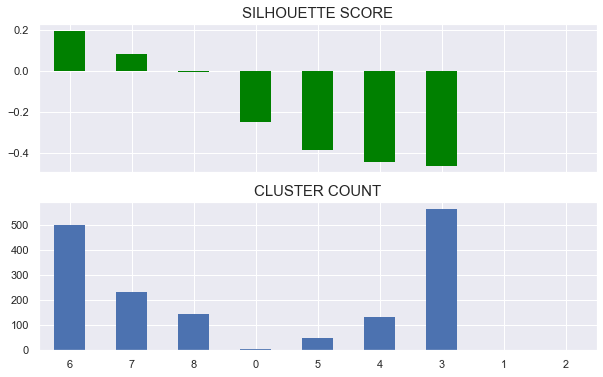

In [269]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)

cluster_scores.loc[:,['cluster_count']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xticks(rotation=1);

## Iterations based on best parameters from above

### eps=1, min_sampels=5 

In [ ]:
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

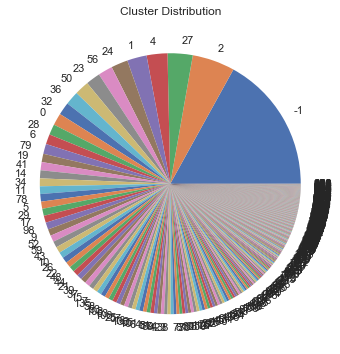

In [153]:
plt.figure(figsize=(6, 6))

clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution')
plt.ylabel('');

With such a large number of clusters I focused on analyzing characteristics within the top 50.

In [768]:
pd.Series(clusters).value_counts()

-1      6517
 2      2024
 27     1193
 4       991
 1       930
        ... 
 496       3
 229       3
 476       3
 442       2
 330       2
Length: 500, dtype: int64

In [155]:
# concat cluster numbers to dataset
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

In [156]:
# subset dataset based on top 50 clusters by size
df_clusters = df_clusters[df_clusters.cluster.isin(list(pd.Series(clusters).value_counts()[1:51].index))]

In [157]:
# how many citations are included in the 
# top 50 clusters
df_clusters.shape

(21002, 7)

In [1]:
# I had to plot this one with an adjustment to the function
# since my x-axis numbers have uneven breaks
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_clusters.drop([
    'cluster',
    'beat',
    'charge_description'
], axis=1)))

# rename colums after minmax scaling
df_scaled.columns = df_clusters.drop([
    'cluster',
    'beat',
    'charge_description'
], axis=1).columns

# set plotting parameters
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 1, 4]}, figsize=(15, 8))

# graph cluster counts for categorical features
ax0 = df_clusters.groupby(['cluster'])['charge_description'].agg('nunique').plot(ax=ax0, kind='bar', alpha=.4, title='Unique Charge Descriptions', color='brown')

# graph cluster counts for categorical features
ax1 = df_clusters.groupby(['cluster'])['beat'].agg('nunique').plot(ax=ax1, kind='bar', alpha=.4, title='Unique Locations Descriptions', color='orange')

# graph continuous cluster features
ax2 = pd.concat([df_scaled, df_clusters['cluster'].astype(str).reset_index()], axis=1).groupby(['cluster']).agg(
                                    {'month' : 'mean',
                                    'day_of_week' : 'mean', 
                                    'hour_of_day' : 'mean',
                                    'cited_person_age' : 'mean'}).plot(ax=ax2, title='Cluster Characteristics', linewidth=3);

NameError: name 'pd' is not defined

All the clusters are made up of one categorical variable each (citation type, and location).  
1. Both clusters 55 and 79 show similar characteristics - lower age and hour of the day with later day of the week.  
1. Cluster 101 and 98 represent the oldest people receiving citations, these are happening at a relatively early day of the day.  
1. Cluster 78 represents the youngest people receiving ciations.
1. Cluster 58 represents the latest citations happening in the day, with no pattern in the age or time of day that these citations are issued.

### Clusters 55 and 79
Both of these clusters represent 654 young people who receive DUI citations early in the day on the weekend within beats 5 & 6.

In [2]:
# how many people are included within these clusters
df_clusters[(df_clusters.cluster == 55) |
            (df_clusters.cluster == 79)].shape

NameError: name 'df_clusters' is not defined

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

NameError: name 'plt' is not defined

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

NameError: name 'plt' is not defined

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'day_of_week'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

NameError: name 'plt' is not defined

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'hour_of_day'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 55) |
                            (df_clusters.cluster == 79)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

NameError: name 'plt' is not defined

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.1)

ax.scatter(df_clusters[(df_clusters.cluster == 55) |
    (df_clusters.cluster == 79)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 55) |
    (df_clusters.cluster == 79)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 55) |
    (df_clusters.cluster == 79)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5);

NameError: name 'plt' is not defined

### Cluster 58
This cluster represent the latest citations happening in the day.  With little preference for age, this cluster is made up of 213 people received DUI citations exclusively within beat #6 very late in the evening.

In [8]:
df_clusters[(df_clusters.cluster == 58)].shape

NameError: name 'df_clusters' is not defined

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 58)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

NameError: name 'plt' is not defined

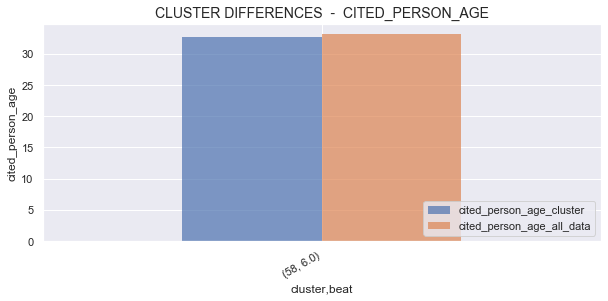

In [797]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 58)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

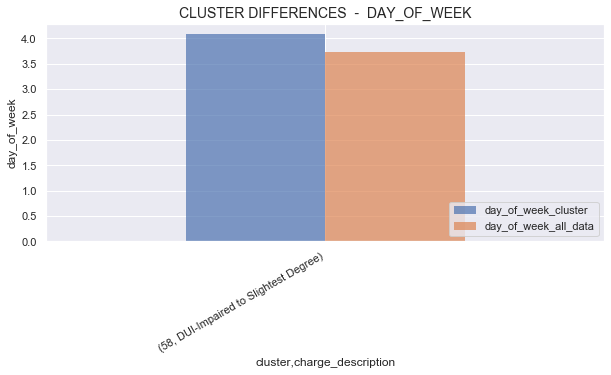

In [795]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'day_of_week'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 58)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

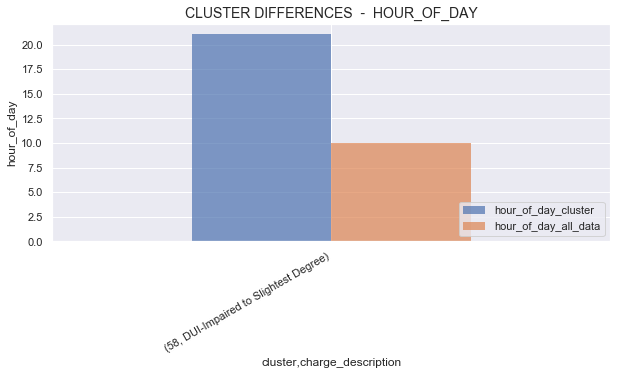

In [796]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'hour_of_day'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 58)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

In [159]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 58)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 58)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 58)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5)

### Clusters 101 and 98
These clusters represent 509 mostly older people who received citations at a relatively early hour of the day within beat locations 12 & 13.

In [799]:
df_clusters[(df_clusters.cluster == 101) |
            (df_clusters.cluster == 98)].shape

(509, 7)

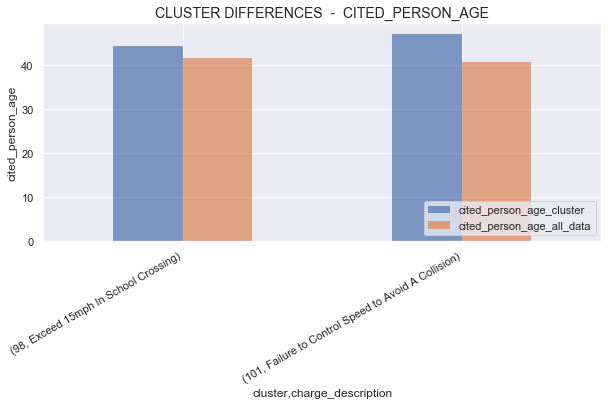

In [783]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 101) |
                            (df_clusters.cluster == 98)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

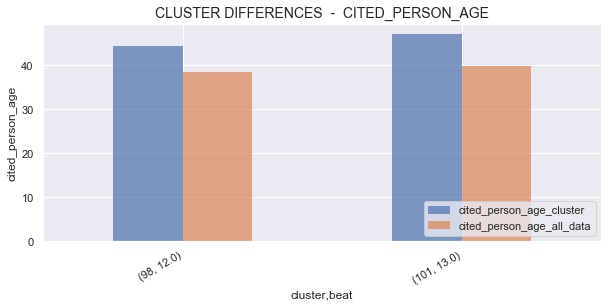

In [784]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 101) |
                            (df_clusters.cluster == 98)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

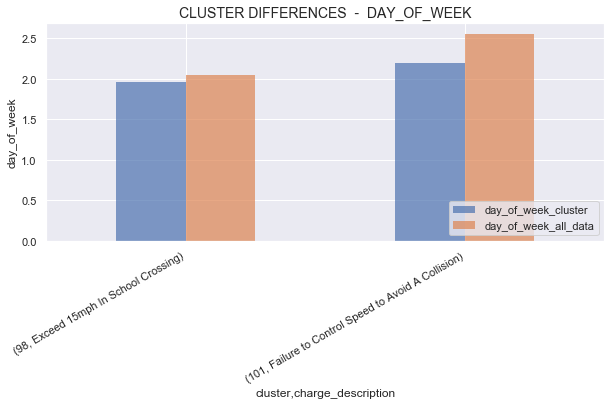

In [785]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'day_of_week'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 101) |
                            (df_clusters.cluster == 98)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

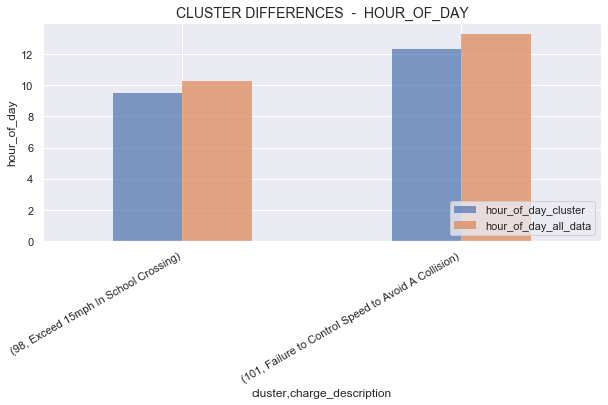

In [786]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'hour_of_day'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 101) |
                            (df_clusters.cluster == 98)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

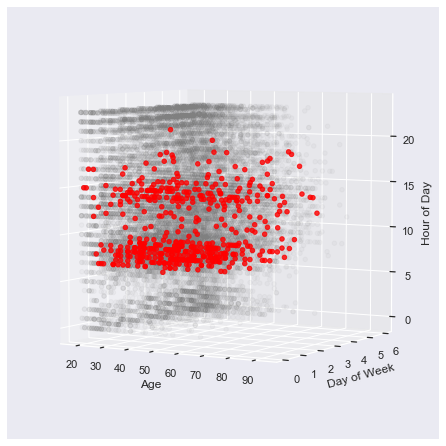

In [160]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 98) |
    (df_clusters.cluster == 101)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 98) |
    (df_clusters.cluster == 101)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 98) |
    (df_clusters.cluster == 101)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5)

### Cluster 78
This cluster represents the youngest mean age within a cluster with 360 people receiving citations for drug paraphernelia within beat 6.  Most of these took place early in the day on the weekend.

In [800]:
df_clusters[(df_clusters.cluster == 78)].shape

(360, 7)

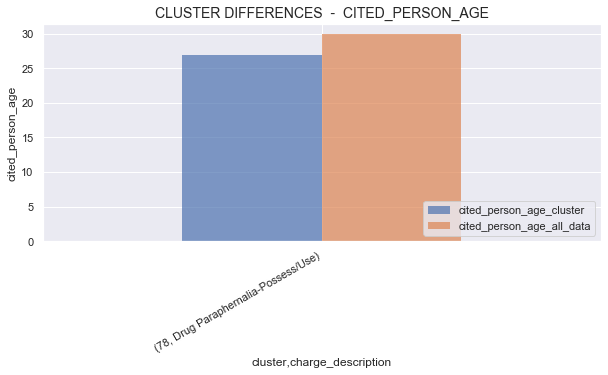

In [789]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

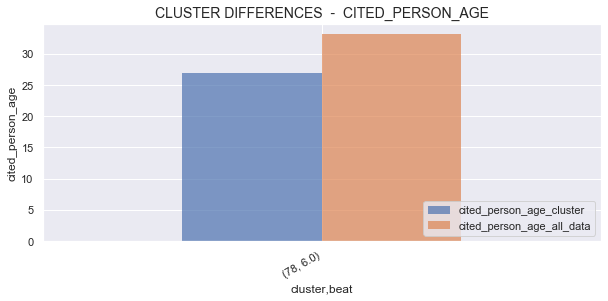

In [791]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'cited_person_age'
aggregator = 'beat'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

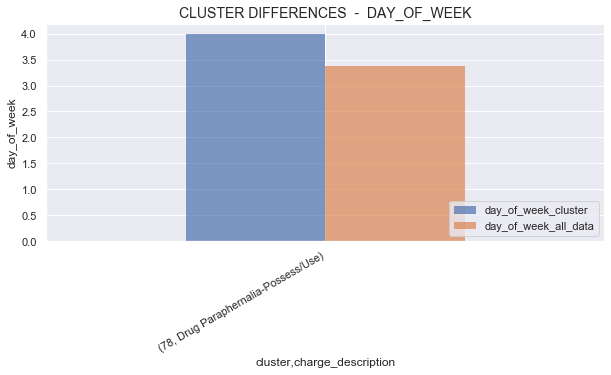

In [792]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'day_of_week'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

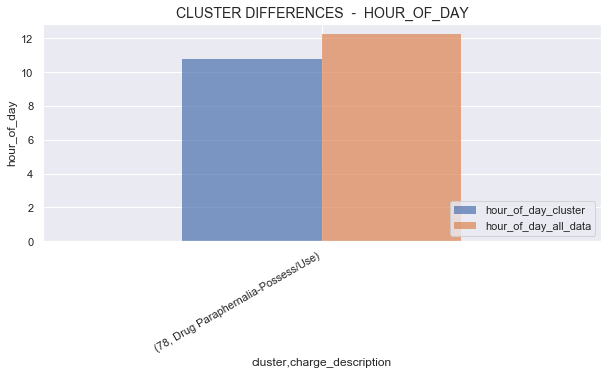

In [793]:
fig, ax = plt.subplots(figsize=(10, 4))

cluster_attribute = 'hour_of_day'
aggregator = 'charge_description'

df_cluster_sub = df_clusters[(df_clusters.cluster == 78)]

df_cluster_sub.groupby(['cluster', aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
df.groupby([aggregator]).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
how='left',
on=aggregator,
suffixes=('_cluster', '_all_data')).set_index(['cluster', aggregator]).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                     kind='bar',
                                                                                                    alpha=.7)
plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
plt.ylabel(cluster_attribute)
plt.legend(loc='lower right')
plt.xticks(rotation=30, horizontalalignment="right");

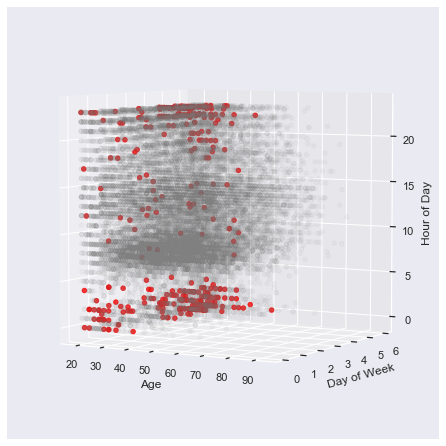

In [161]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 78)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 78)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 78)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5)

### eps=1, min_sampels=10
Examining the second best parameter configuration based on silhouette coefficient. 

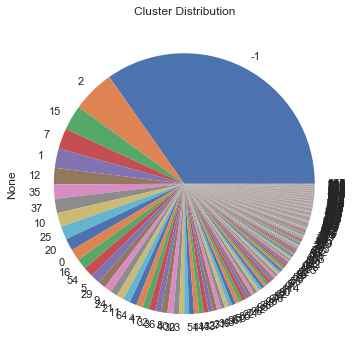

In [655]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=1, min_samples=10)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Exploring parameters from the next highest silhouette coefficient, a larger share of citations are categorized as not fitting into any cluster.

Clusters 1 and 37 seem to show the most interesting trends.

### Cluster #37
This cluster has the lowest age, along with the highest values for day_of_week and hour_of_day.

#### Cluster #37 Summary:
This cluster is made up of over 600 citations representing much younger people who receive speeding tickets in beat #6 later in the day, and later in the week.  

### Cluster #1

#### Cluster #10 Summary:
This cluster is made up of over 600 citations representing people who receive speeding tickets in beat #10.  This cluster is less defined that that of cluster 37.

Compared with the previous DBSCAN iteration, fewer citations are categorized as not fitting into a cluster.

In an effort to identify smaller clusters with characteristics different from the full citation datset, I focused the DBSCAN model with a smaller sample size.

##### Cluster #17 Summary:
This cluster is made up of 46 citations representing people who receive DUI tickets in beat #6.  All of these tickets took place in the early morning hours on Sunday with an average month of the year of August.  Additionaly, these tickets were received by people at least 10 year younger than average for this citation type.

#### Cluster #7 Summary:
This cluster is quite similar to cluster 17 above.  It is made up of 79 citations representing people younger people who received DUI tickets in beat #6.  The two exceptions from cluster 17 is that the average month of the year is August, and all these citations were received in the early morning on Saturday, rather than Sunday.

### DBSCAN Clustering Summary:
This model did a good job of finding very tight clusters with highly similar characteristics.  This model overwhelmingly clustered based off the categorical features (citation type, and location(beat)).

## Examine Clusters Visually

### PCA

In [38]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

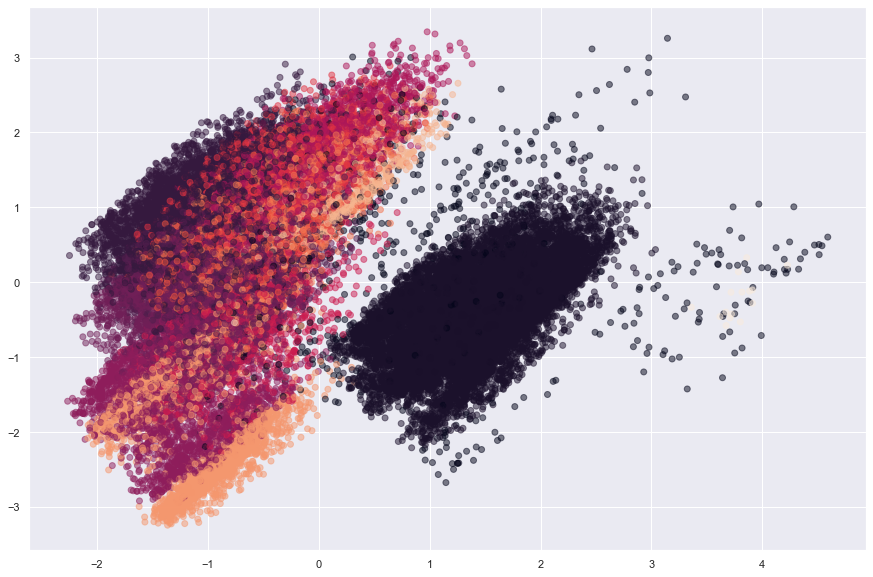

In [39]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [40]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 38417 samples in 0.814s...
[t-SNE] Computed neighbors for 38417 samples in 38.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38417
[t-SNE] Computed conditional probabilities for sample 2000 / 38417
[t-SNE] Computed conditional probabilities for sample 3000 / 38417
[t-SNE] Computed conditional probabilities for sample 4000 / 38417
[t-SNE] Computed conditional probabilities for sample 5000 / 38417
[t-SNE] Computed conditional probabilities for sample 6000 / 38417
[t-SNE] Computed conditional probabilities for sample 7000 / 38417
[t-SNE] Computed conditional probabilities for sample 8000 / 38417
[t-SNE] Computed conditional probabilities for sample 9000 / 38417
[t-SNE] Computed conditional probabilities for sample 10000 / 38417
[t-SNE] Computed conditional probabilities for sample 11000 / 38417
[t-SNE] Computed conditional probabilities for sample 12000 / 38417
[t-SNE] Computed conditional probabilities for s

In [41]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [42]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

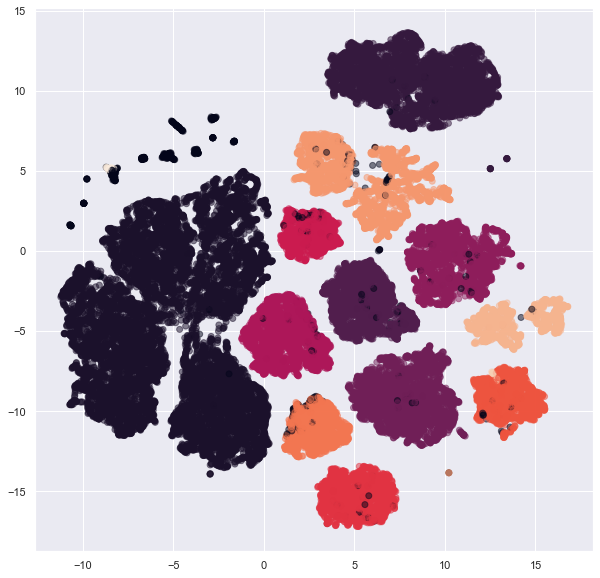

In [43]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));


## CLUSTER USING GMM
<a id='GMM'></a>

GMM Parameters to explore
 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

In [713]:
# find best GMM parameters
sil_score = []
num_components = []
cov_type = []

for n_components in range(10, 31, 5):
    for covariance_type in ['full', 'tied', 'diag', 'spherical']:
    
        # Defining the agglomerative clustering
        gmm_cluster = GaussianMixture(n_components=n_components, covariance_type=covariance_type)

        # Fit model
        clusters = gmm_cluster.fit_predict(X_std)
        
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        
        # record parameter values
        num_components.append(n_components)
        cov_type.append(covariance_type)

In [714]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, num_components, cov_type))), 
            columns=['sil_score', 'num_components', 'covariance_type']) \
        .sort_values(by=['sil_score'], ascending=False)

cluster_scores

sil_score  num_components covariance_type
12      0.308              25            full
14      0.302              25            diag
8       0.301              20            full
16      0.286              30            full
15      0.281              25       spherical
18      0.276              30            diag
19      0.267              30       spherical
13      0.256              25            tied
17      0.254              30            tied
9       0.254              20            tied
10      0.243              20            diag
7       0.221              15       spherical
11      0.215              20       spherical
6       0.214              15            diag
5       0.210              15            tied
4       0.206              15            full
1       0.151              10            tied
2       0.148              10            diag
0       0.136              10            full
3       0.032              10       spherical

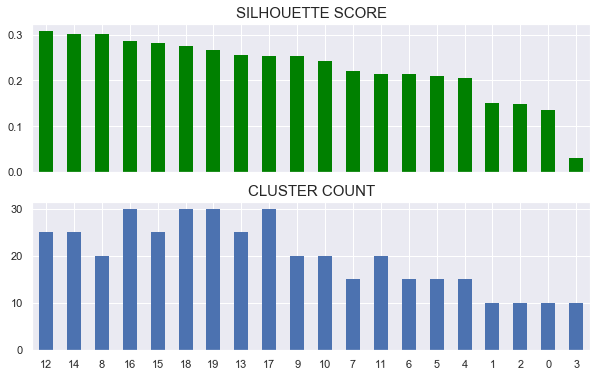

In [715]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)

cluster_scores.loc[:,['num_components']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xticks(rotation=1);

The silhouette score at 25 components is significantly higher than that of DBSCAN at .197.

In [143]:
# create model
gmm_cluster = GaussianMixture(n_components=25, covariance_type='full')

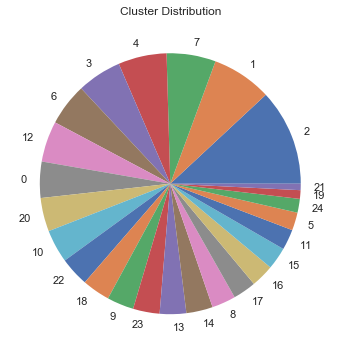

In [144]:
plt.figure(figsize=(6, 6))

clusters = gmm_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution')
plt.ylabel('');

Compared to DBSCAN, the size distribution of GMM is much more distributed.

In [146]:
# join cluster assignment to df
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

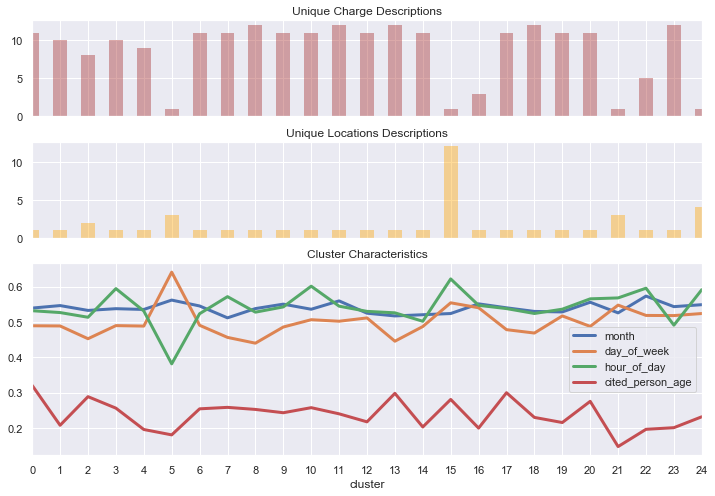

In [152]:
plot_clusters_scaled(df_clusters)

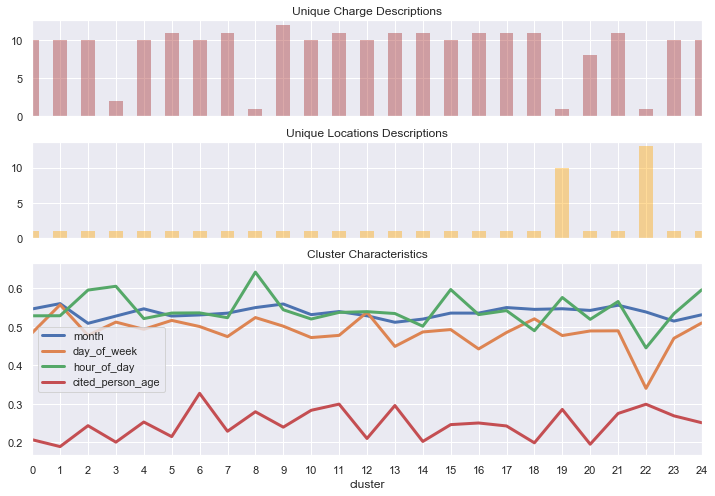

In [720]:
plot_clusters_scaled(df_clusters)

### EXAMINE SPECIFIC CLUSTERS THAT STAND OUT

### Cluster 22 
This cluster is made up of tickets for speeding in school zones.  It has a high diversity of beat locations.  This citation also happens mostly early in the morning, and almost exclusively early in the week.

In [722]:
plot_clusters(df, df_clusters, 'beat', 'cited_person_age', 22)

In [723]:
plot_clusters(df, df_clusters, 'beat', 'hour_of_day', 22)

In [724]:
plot_clusters(df, df_clusters, 'beat', 'day_of_week', 22)

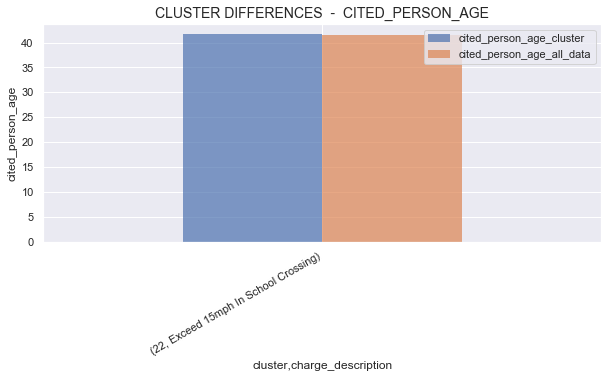

In [721]:
plot_clusters(df, df_clusters, 'charge_description', 'cited_person_age', 22)

### Cluster 6:

This cluster is made up of XXX people who received a citation with beat 20.  This cluster is made up of a high number of uniqe citation types with no unique qualities about the time of day or day of the week these citations were issued.


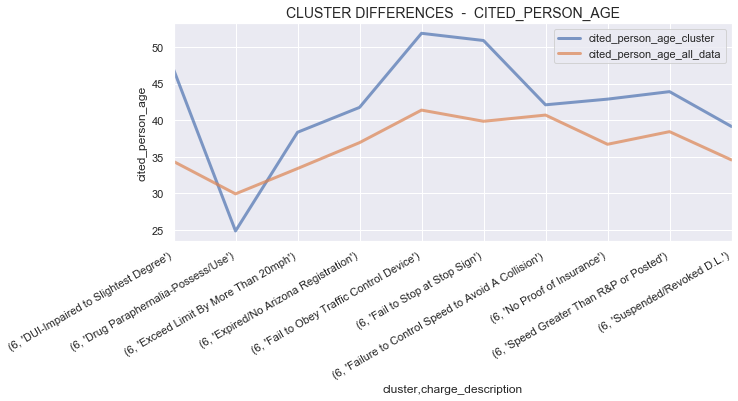

In [725]:
plot_clusters(df, df_clusters, 'charge_description', 'cited_person_age', 6)

In [727]:
plot_clusters(df, df_clusters, 'beat', 'cited_person_age', 6)

### Cluster 8:
This cluster has the latest average time of day and is made up 1136 people who receive citations for "Expired/No Arizona Registration".  This cluster's location is exclusively within beat 11.

In [149]:
df_clusters[df_clusters.cluster == 8].shape

(1136, 7)

# Find count of people who receive this citation.

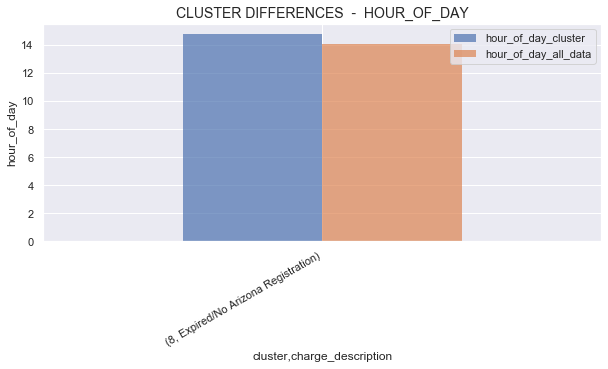

In [729]:
plot_clusters(df, df_clusters, 'charge_description', 'hour_of_day', 8)

In [728]:
plot_clusters(df, df_clusters, 'charge_description', 'cited_person_age', 8)

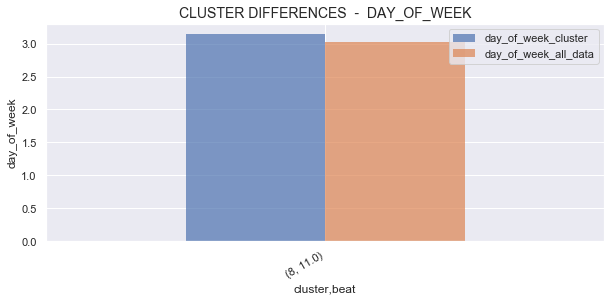

In [731]:
plot_clusters(df, df_clusters, 'beat', 'day_of_week', 8)

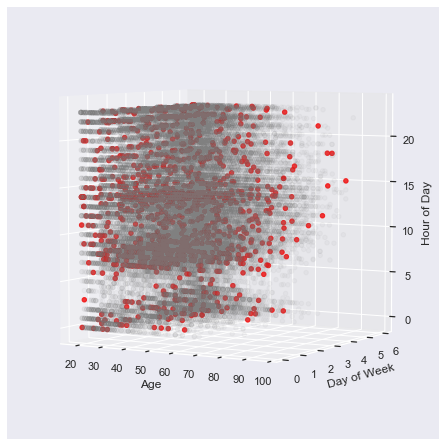

In [147]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 8)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 8)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 8)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5)
#              , azim=45)

### GMM Clustering Summary:
Although this model classified all citations into one of 25 clusters, the specific characteristics of each cluster were not as strong as those within the smaller DBSCAN clusters.

This model was able to cluster more strongly than DBSCAN using characteristics other than citation type and location.  Whereas all the DBSCAN clusters were made up of onlye one citation type and one location, a number of GMM clusters included a number of unique citation types and locations.

## Examine Clusters Visually

### PCA

In [105]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

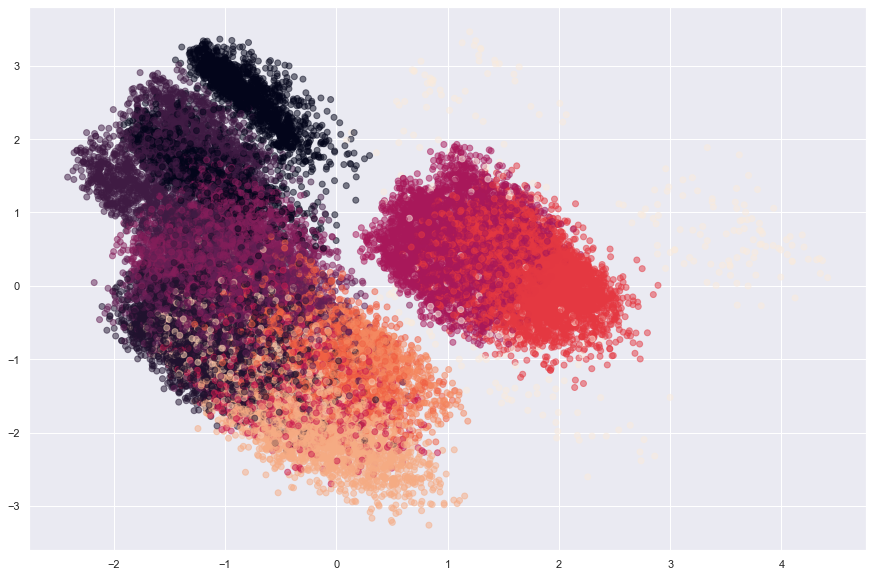

In [106]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [107]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 38417 samples in 0.664s...
[t-SNE] Computed neighbors for 38417 samples in 34.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38417
[t-SNE] Computed conditional probabilities for sample 2000 / 38417
[t-SNE] Computed conditional probabilities for sample 3000 / 38417
[t-SNE] Computed conditional probabilities for sample 4000 / 38417
[t-SNE] Computed conditional probabilities for sample 5000 / 38417
[t-SNE] Computed conditional probabilities for sample 6000 / 38417
[t-SNE] Computed conditional probabilities for sample 7000 / 38417
[t-SNE] Computed conditional probabilities for sample 8000 / 38417
[t-SNE] Computed conditional probabilities for sample 9000 / 38417
[t-SNE] Computed conditional probabilities for sample 10000 / 38417
[t-SNE] Computed conditional probabilities for sample 11000 / 38417
[t-SNE] Computed conditional probabilities for sample 12000 / 38417
[t-SNE] Computed conditional probabilities for s

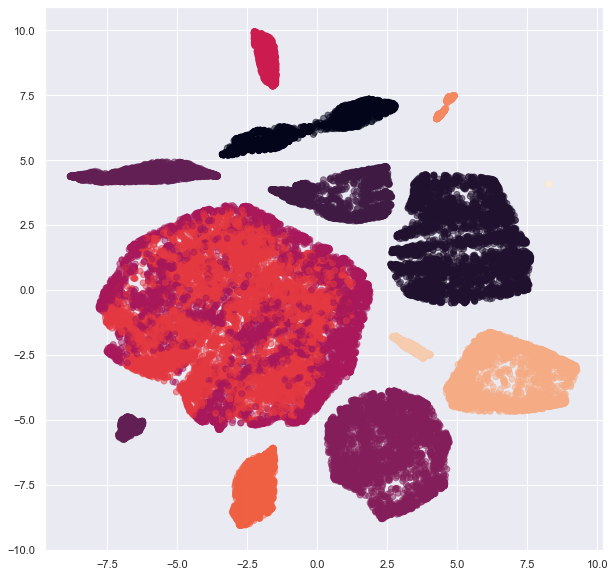

In [108]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [109]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

In [110]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

<a id='Hierarchical'></a>
## HIERARCHICAL CLUSTERING
Since I'm not necessarily expecting clusters of equal sizes I will use 'average' linkage method.

In [194]:
# plt.figure(figsize=(6, 6))
# agg_cluster = AgglomerativeClustering(linkage='average', 
#                                       affinity='cosine',
#                                       n_clusters=13)

# clusters = agg_cluster.fit_predict(X_std)
# pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Running the above produced "MemoryError: unable to allocate array data."  So I sampled 10000 citations below.

In [15]:
# select 10000 random rows
rand_index = np.random.choice(X_std.shape[0], size=10000)

In [16]:
# subset the full dataset
X_std_sample = X_std[rand_index,:]

In [550]:
# find best parameters
cluster_count = []
sil_score = []
cluster_param = []

for i in range(2, 27, 4):
    
    # Defining the clustering model
    agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=i)

    # Fit model
    clusters = agg_cluster.fit_predict(X_std_sample)

    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std_sample, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

    # record parameter values
    cluster_param.append(i)

In [551]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, cluster_count, n_clusters_ct))), 
            columns=['sil_score', 'cluster_count', 'cluster_param']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

sil_score  cluster_count  cluster_param
2      0.400             10             10
3      0.369             14             14
4      0.341             18             18
5      0.315             22             22
6      0.310             26             26
1      0.254              6              6
0      0.095              2              2

In [552]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)


cluster_scores.loc[:,['cluster_count']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xticks(rotation=1);

In [101]:
# create clustering model
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=10)

In [138]:
# use model to assign cluster labels
plt.figure(figsize=(6, 6))

clusters = agg_cluster.fit_predict(X_std_sample)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution', )
plt.ylabel('');

In [128]:
pd.Series(clusters).value_counts(dropna=False)

0    2592
2    2382
4    1380
5    1055
1     722
3     464
8     397
9     395
6     320
7     293
dtype: int64

In [129]:
# join cluster assignment to df
df_clusters = pd.concat([df.iloc[pd.Series(rand_index)].reset_index(drop=True),
                         pd.Series(clusters).rename('cluster')], 
                        axis=1)

### EXAMINE CLUSTERS BY LOOKING AT EACH FEATURE


In [25]:
plot_clusters_scaled(df_clusters)

### EXAMINE SPECIFIC CLUSTERS THAT STAND OUT

### Cluster 0
This cluster, made up of 2592 citations, has the highest mean age and is made up of a number of unique citations and locations.

In [139]:
df_clusters[df_clusters.cluster == 0].shape

(2592, 7)

In [40]:
plot_clusters(df, df_clusters, 'beat', 'cited_person_age', 0)

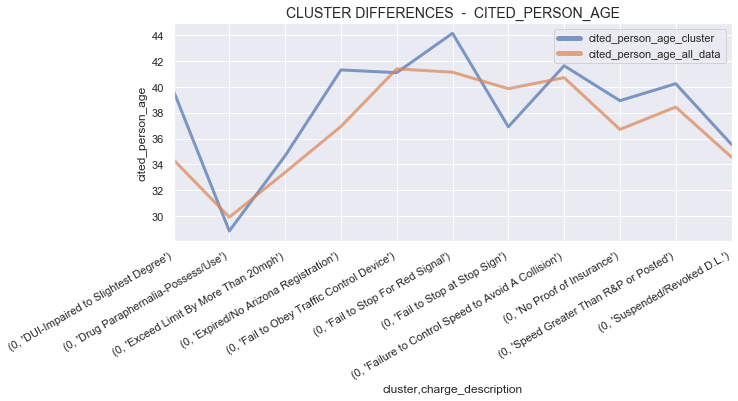

In [41]:
plot_clusters(df, df_clusters, 'charge_description', 'cited_person_age', 0)

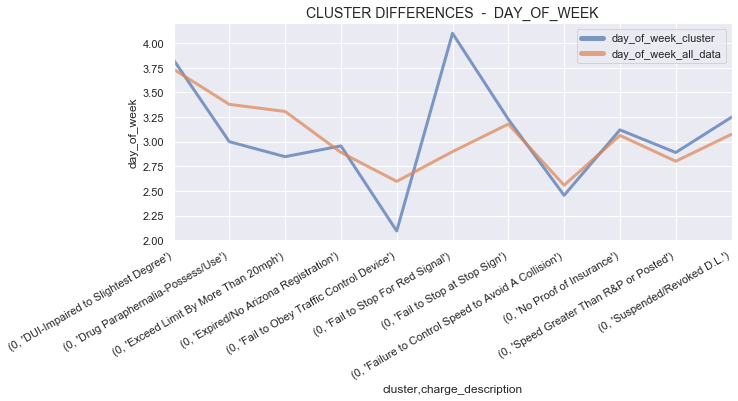

In [42]:
plot_clusters(df, df_clusters, 'charge_description', 'day_of_week', 0)

In [43]:
plot_clusters(df, df_clusters, 'charge_description', 'hour_of_day', 0)

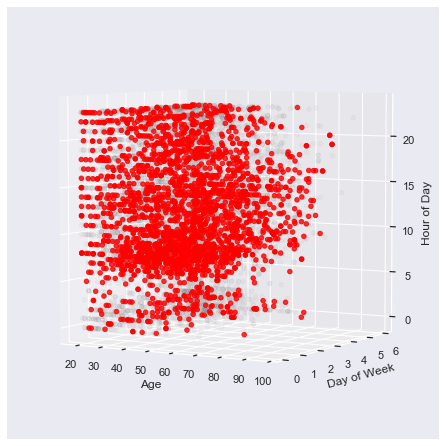

In [130]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 0)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 0)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 0)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5)
#              , azim=45)

### Cluster 2
This cluster, made up of 2382 citations, has the lowest mean age and is made up of a number of unique citations and locations.

In [141]:
df_clusters[df_clusters.cluster == 2].shape

(2382, 7)

In [36]:
plot_clusters(df, df_clusters, 'beat', 'cited_person_age', 2)

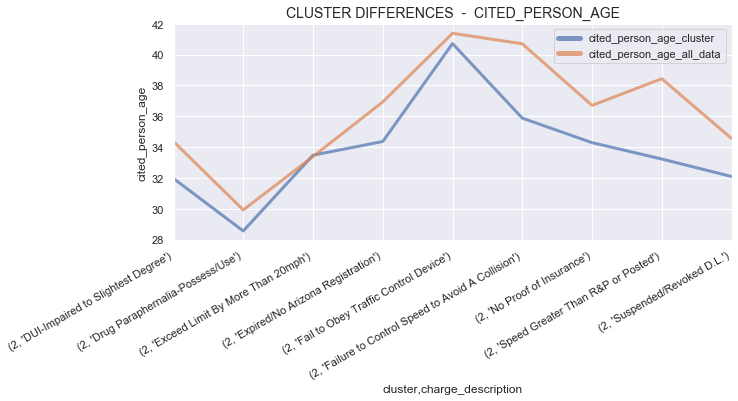

In [37]:
plot_clusters(df, df_clusters, 'charge_description', 'cited_person_age', 2)

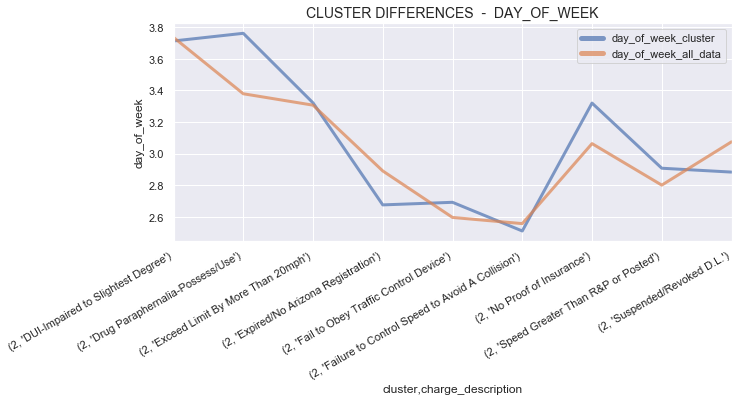

In [38]:
plot_clusters(df, df_clusters, 'charge_description', 'day_of_week', 2)

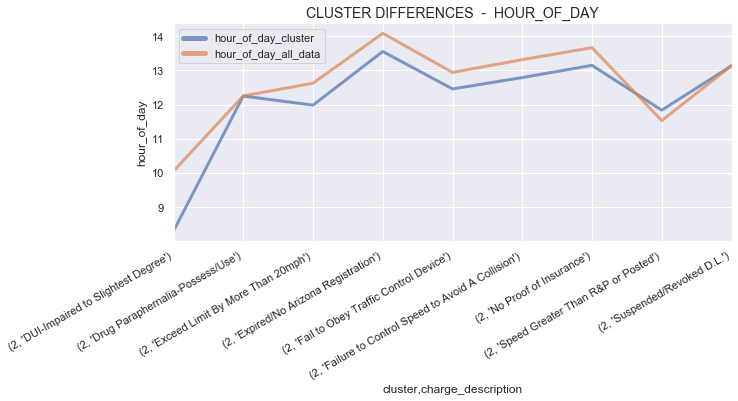

In [39]:
plot_clusters(df, df_clusters, 'charge_description', 'hour_of_day', 2)

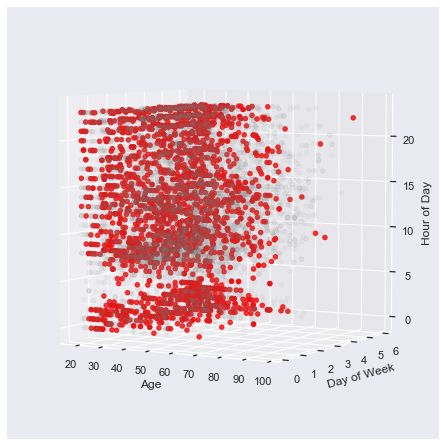

In [131]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 2)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 2)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 2)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=5)
#              , azim=45)

### Cluster 3
This cluster, made up of 464 citations, is associated with the latest mean hour of the day.

In [142]:
df_clusters[df_clusters.cluster == 3].shape

(464, 7)

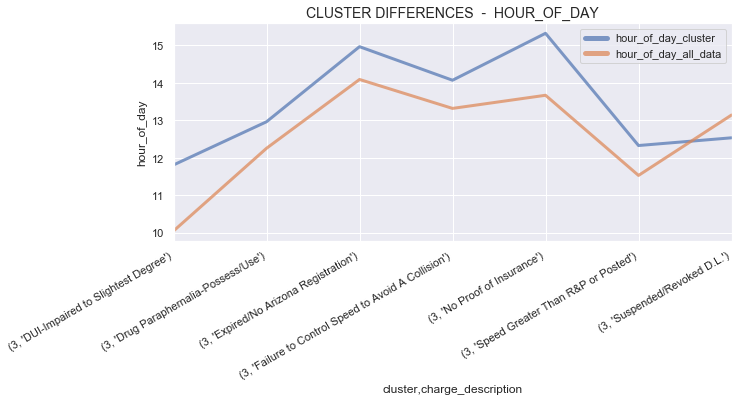

In [46]:
plot_clusters(df, df_clusters, 'charge_description', 'hour_of_day', 3)

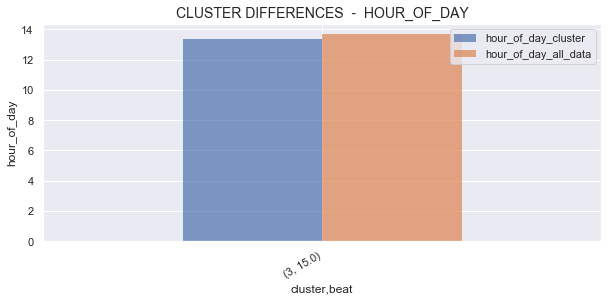

In [47]:
plot_clusters(df, df_clusters, 'beat', 'hour_of_day', 3)

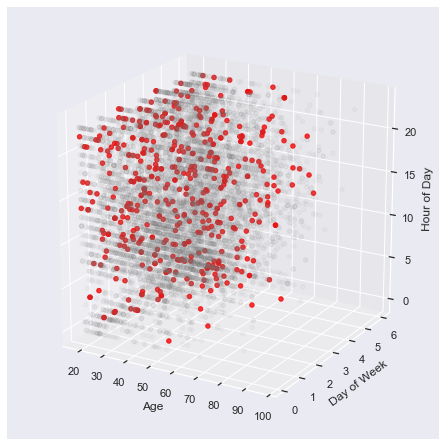

In [134]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)

ax.scatter(df_clusters.loc[:,'cited_person_age'], 
           df_clusters.loc[:,'day_of_week'], 
           df_clusters.loc[:,'hour_of_day'],
           c='grey',
          alpha=.05)

ax.scatter(df_clusters[(df_clusters.cluster == 3)].loc[:,'cited_person_age'], 
               df_clusters[(df_clusters.cluster == 3)].loc[:,'day_of_week'], 
               df_clusters[(df_clusters.cluster == 3)].loc[:,'hour_of_day'],
               c='red',
          alpha=.8)
  
ax.set_xlabel('Age')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Hour of Day')

ax.view_init(elev=20)
#              , azim=45)

### Hierarcical Clustering Summary:

Although this model classified all citations into one of 10 clusters with a silhouette coefficient higher than either GMM or DBSCAN, the specific characteristics of each cluster were not as strong as those within the smaller DBSCAN or GMM clusters.

### SPARE PARTS